In [1]:
# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    round, count, avg, col, udf, abs, mean, expr
)
from pyspark.sql.types import IntegerType, FloatType

# Other imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time


In [2]:
#number of spark workers
n_workers = "2"

spark_session = SparkSession.builder\
        .master("spark://192.168.2.145:7077") \
        .appName("")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.dynamicAllocation.minExecutors", n_workers)\
        .config("spark.dynamicAllocation.maxExecutors", n_workers)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

# create spark context and set log level to warn
spark_context = spark_session.sparkContext

spark_context.setLogLevel("WARN")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/11 14:58:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/11 14:58:18 WARN StandaloneSchedulerBackend: Dynamic allocation enabled without spark.executor.cores explicitly set, you may get more executors allocated than expected. It's recommended to set spark.executor.cores explicitly. Please check SPARK-30299 for more details.
24/03/11 14:58:19 WARN Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.


In [3]:
#returns a score based on the difference from the "perfect" bpm
def get_bpm_range(bpm_diff):
    if bpm_diff < 10:
        return 0.6
    elif bpm_diff < 20:
        return 0.4
    elif bpm_diff < 30:
        return 0.3
    elif bpm_diff < 40:
        return 0.1
    else:
        return 0.0
#returns a score based on the difference from the "perfect" loudness

def get_loudness_range(loudness_diff):
    if loudness_diff < 2:
        return 0.4
    elif loudness_diff < 15:
        return 0.3
    elif loudness_diff < 35:
        return 0.2
    elif loudness_diff < 40:
        return 0.1
    else:
        return 0.0

get_bpm_range_udf = udf(get_bpm_range, FloatType())
get_loudness_range_udf = udf(get_loudness_range, FloatType())

#calculates the danceability based on loudness and bpm cols in a spark dataframe
def calculate_danceability(loudness_col, bpm_col):
    # Calculate differences
    loudness_diff = abs(loudness_col + 7)
    bpm_diff = abs(bpm_col - 120)

    # Get the scores 
    loudness_score = get_loudness_range_udf(loudness_diff)
    bpm_score = get_bpm_range_udf(bpm_diff)

    # Calculate danceability
    danceability = bpm_score + loudness_score
    
    return danceability

#year to decade function, year must be an int
def year_to_decade_udf(year):
    return year - (year % 10)

year_to_decade_spark_udf = udf(year_to_decade_udf, IntegerType())

#pruning function for spark dataframe
def prune_data(df):
    # Remove rows with missing values
    df = df.dropna()
    # Remove rows with invalid values
    df = df.filter((col('year') > 0) &
                   (col('bpm') > 0) & (col('bpm') < 300) &
                   (col('loudness') > -100) & (col('loudness') < 0))
    return df

#preprocess data, drop unneccesary columns, calculate danceablity and change years to decae
def preprocess_data(df):
    # Calculate danceability
    df = df.withColumn('year', col('year').cast(IntegerType()))
    df = df.withColumn('loudness', col('loudness').cast(IntegerType()))
    df = df.withColumn('bpm', col('bpm').cast(IntegerType()))
    pruned_df = prune_data(df)
    #calculate the danceability and round it
    pruned_df = pruned_df.withColumn('danceability', calculate_danceability(col('loudness'), col('bpm')))
    pruned_df = pruned_df.withColumn('danceability', round(col('danceability'), 2))
    #change the years into decades
    pruned_df = pruned_df.withColumn('decade', year_to_decade_spark_udf(col('year')))
    pruned_df = pruned_df.drop('loudness', 'bpm', 'year')
    return pruned_df


running :)


Number of Rows in original df: 20000000
Number of Columns in original df: 3


Number of Rows after preprocessing: 9121286
Number of Columns after preprocessing: 2


+------------+------+
|danceability|decade|
+------------+------+
|         0.5|  1990|
|         0.6|  2000|
|         0.3|  2030|
|         0.8|  2010|
|         0.3|  2010|
|         0.7|  2010|
|         0.3|  2030|
|         0.3|  2030|
|         0.3|  2010|
|         0.9|  2030|
+------------+------+
only showing top 10 rows



+------+-----------------+-------------------+-------+
|decade|mean_danceability|median_danceability|  count|
+------+-----------------+-------------------+-------+
|  1990|             0.53|                0.6|  25865|
|  2040|             0.41|                0.3|2563716|
|  1950|             0.54|                0.6|    391|
|  2060|             0.36|                0.3| 748104|
|  2030|             0.42|                0.3|1290087|
|  2020|              0.4|                0.3| 622650|
|  1960|             0.51|                0.6|   2147|
|  1970|             0.43|                0.4|  10875|
|  2050|             0.39|                0.3|3414114|
|  1980|             0.48|                0.4|  14036|
+------+-----------------+-------------------+-------+
only showing top 10 rows



+------------+-------+
|danceability|  count|
+------------+-------+
|         0.2|1892672|
|         0.3|3473662|
|         0.4|1112639|
|         0.5| 464688|
|         0.6| 914216|
|         0.7| 628164|
|         0.8| 265344|
|         0.9| 312986|
|         1.0|  56915|
+------------+-------+



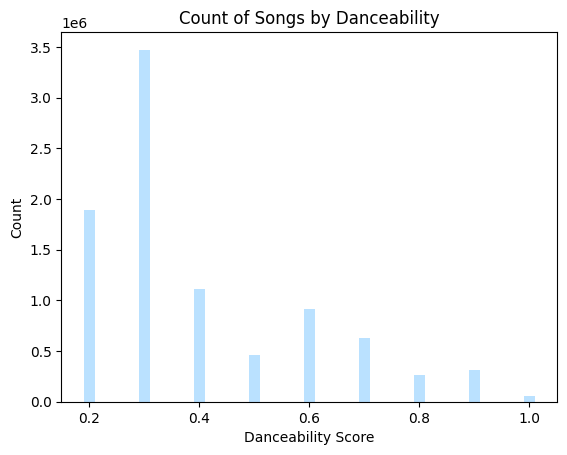

Number of Rows in original df: 20000000
Number of Columns in original df: 3


Number of Rows after preprocessing: 9121286
Number of Columns after preprocessing: 2
+------------+------+
|danceability|decade|
+------------+------+
|         0.5|  1990|
|         0.6|  2000|
|         0.3|  2030|
|         0.8|  2010|
|         0.3|  2010|
|         0.7|  2010|
|         0.3|  2030|
|         0.3|  2030|
|         0.3|  2010|
|         0.9|  2030|
+------------+------+
only showing top 10 rows



+------+-----------------+-------------------+-------+
|decade|mean_danceability|median_danceability|  count|
+------+-----------------+-------------------+-------+
|  1990|             0.53|                0.6|  25865|
|  2040|             0.41|                0.3|2563716|
|  1950|             0.54|                0.6|    391|
|  2060|             0.36|                0.3| 748104|
|  2030|             0.42|                0.3|1290087|
|  2070|             0.33|                0.3|    625|
|  2020|              0.4|                0.3| 622650|
|  1960|             0.51|                0.6|   2147|
|  1970|             0.43|                0.4|  10875|
|  2050|             0.39|                0.3|3414114|
+------+-----------------+-------------------+-------+
only showing top 10 rows



+------------+-------+
|danceability|  count|
+------------+-------+
|         0.2|1892672|
|         0.3|3473662|
|         0.4|1112639|
|         0.5| 464688|
|         0.6| 914216|
|         0.7| 628164|
|         0.8| 265344|
|         0.9| 312986|
|         1.0|  56915|
+------------+-------+



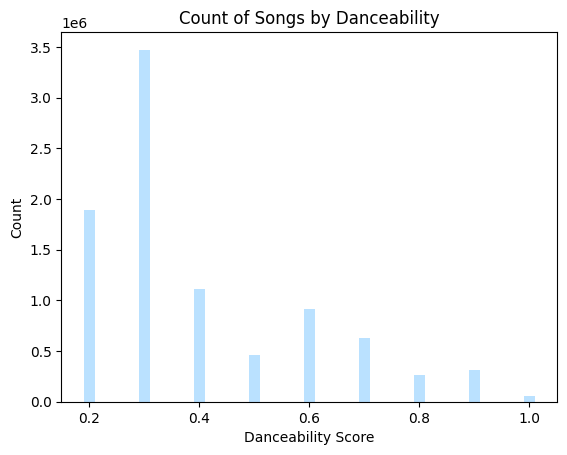

Number of Rows in original df: 20000000
Number of Columns in original df: 3


Number of Rows after preprocessing: 9121286
Number of Columns after preprocessing: 2
+------------+------+
|danceability|decade|
+------------+------+
|         0.5|  1990|
|         0.6|  2000|
|         0.3|  2030|
|         0.8|  2010|
|         0.3|  2010|
|         0.7|  2010|
|         0.3|  2030|
|         0.3|  2030|
|         0.3|  2010|
|         0.9|  2030|
+------------+------+
only showing top 10 rows



+------+-----------------+-------------------+-------+
|decade|mean_danceability|median_danceability|  count|
+------+-----------------+-------------------+-------+
|  1990|             0.53|                0.6|  25865|
|  2040|             0.41|                0.3|2563716|
|  1950|             0.54|                0.6|    391|
|  2060|             0.36|                0.3| 748104|
|  2030|             0.42|                0.3|1290087|
|  2070|             0.33|                0.3|    625|
|  2020|              0.4|                0.3| 622650|
|  1960|             0.51|                0.6|   2147|
|  1970|             0.43|                0.4|  10875|
|  2050|             0.39|                0.3|3414114|
+------+-----------------+-------------------+-------+
only showing top 10 rows



+------------+-------+
|danceability|  count|
+------------+-------+
|         0.2|1892672|
|         0.3|3473662|
|         0.4|1112639|
|         0.5| 464688|
|         0.6| 914216|
|         0.7| 628164|
|         0.8| 265344|
|         0.9| 312986|
|         1.0|  56915|
+------------+-------+



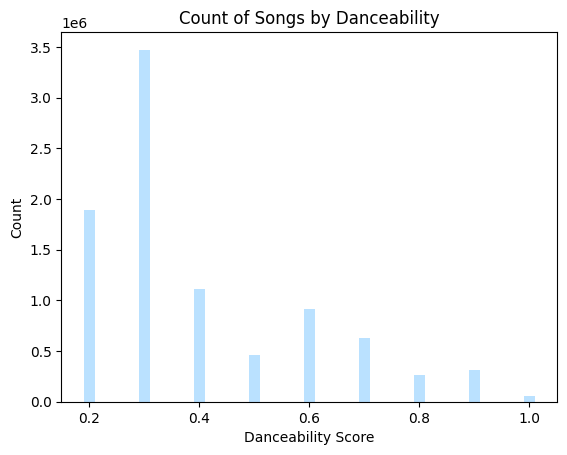

Times with 2 workers:
For file:hdfs://192.168.2.145:5000/de11project/aggregated_song_features_2000x.csv
[213.57880687713623, 197.08284664154053, 197.88439202308655]
Average time: 202.84868184725443


In [4]:
#list to save the times for each run and number of runs
times = []
num_runs = 3
print('running :)')

for _ in range(num_runs):
    #get start time
    start = time.time()
    
    file_path = 'hdfs://192.168.2.145:5000/de11project/aggregated_song_features_2000x.csv' 
    
    # Read the CSV file into a spark dataframe
    spark_df = spark_session.read.format("csv")\
        .option("header", "true")\
        .load(file_path)
 
    # printing number of rows and cols 
    num_rows = spark_df.count()
    num_columns = len(spark_df.columns)
    
    print("Number of Rows in original df:", num_rows)
    print("Number of Columns in original df:", num_columns)

    #preprocess data and counting number of rows and cols
    preprocessed_df = preprocess_data(spark_df)
    
    num_columns = len(preprocessed_df.columns)
    num_rows = preprocessed_df.count()
    
    print("Number of Rows after preprocessing:", num_rows)
    print("Number of Columns after preprocessing:", num_columns)

    #show the first 10 rows of preprocessed data
    preprocessed_df.show(10)

    #get mean and median values grouped by decade
    grouped_decade = preprocessed_df.groupBy('decade')\
    .agg(mean('danceability').alias('mean_danceability'), 
         expr('percentile_approx(danceability, 0.5)').alias('median_danceability'), 
         count('*').alias('count'))\
    .withColumn('mean_danceability', round('mean_danceability', 2))\
    .withColumn('median_danceability', round('median_danceability', 2))\
    .select('decade', 'mean_danceability', 'median_danceability', 'count')
    
    # Show the first 10 rows of the grouped data
    grouped_decade.show(10)
    
    #collect decades for plotting
    decades = grouped_decade.select('decade').rdd.flatMap(lambda x: x).collect()

    #collect mean danceablity to plot
    mean_danceability = grouped_decade.select('mean_danceability').rdd.flatMap(lambda x: x).collect()
    
    # Plotting mean graph
    #plt.bar(decades, mean_danceability, color='#ffdfba', width=2)
    #plt.xticks(rotation=45)
    #plt.ylabel('Mean Danceability')
    #plt.xlabel('Decade')
    #plt.title('Mean Danceability by Decade')
    #plt.savefig('../images/mean_danceability_by_decade.png', bbox_inches='tight')
    #plt.show()
    
    #collect median danceablity to plot
    median_danceability = grouped_decade.select('median_danceability').rdd.flatMap(lambda x: x).collect()
    
    # Plotting median graph
    #plt.bar(decades, median_danceability, color='#ffb3ba', width=2)
    #plt.xticks(rotation=45)
    #plt.ylabel('Median Danceability')
    #plt.xlabel('Decade')
    #plt.title('Median Danceability by Decade')
    #plt.savefig('../images/median_danceability_by_decade.png', bbox_inches='tight')
    plt.show()
    
    # Group by rounded danceability scores and count the number of songs for each score
    danceability_score_count = preprocessed_df.groupBy('danceability').count().orderBy('danceability')

    # Show the result
    danceability_score_count.show()
    
    # Collect data to plot
    scores = danceability_score_count.select('danceability').rdd.flatMap(lambda x: x).collect()
    counts = danceability_score_count.select('count').rdd.flatMap(lambda x: x).collect()
    
    # Plotting
    plt.bar(scores, counts, color='#bae1ff', width=0.02)
    plt.xticks(rotation=0)
    plt.ylabel('Count')
    plt.xlabel('Danceability Score')
    plt.title('Count of Songs by Danceability')
    plt.savefig('../images/count_of_songs_by_danceability.png', bbox_inches='tight')
    plt.show()

    #get end time
    end = time.time()
    times.append(end - start)

print(f"Times with {n_workers} workers:")
print(f"For file:{file_path}")
print(times)
print(f"Average time: {np.mean(times)}")



In [5]:
#stopping the spark session
spark_session.stop()